In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import glob
import pickle
import numpy
import pandas as pd
from music21 import converter, instrument, note, chord
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import SimpleRNN,LSTM
from keras.layers import Activation
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import BatchNormalization as BatchNorm
from keras.layers import Masking
from tensorflow.keras import optimizers

# Constants

In [3]:
def bind(notes, bindings):
    encoded = []
    for note in notes:
        encoded += [bindings[note]]
    return encoded

In [4]:
def most_frequent(List):
    while(1):
        com = max(set(List), key = List.count)
        if max(set(List), key = List.count) > 400:
            temp = []
            for i in List:
                if i < 400:
                    temp += [i]
            List = temp
        else:
            return com

In [5]:
def prepare_sequences(notes, bindings, n_vocab):
    sequence_length = 100
    network_input = []
    network_output = []
    for i in range(0, len(notes) - sequence_length, sequence_length+10):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length: i + sequence_length + 10]
        common = most_frequent(bind(sequence_in, bindings))
        temp_1 = []
        for note in sequence_in:
            if bindings[note] >= 400:
                temp_1 += [common]
            else:
                temp_1 += [bindings[note]]
        network_input.append(temp_1)
        network_output += [bind(sequence_out, bindings)]
    network_input = numpy.reshape(network_input, (len(network_input), 100, 1))
    #normalized_input = network_input / float(n_vocab)
    return (network_input, network_output)

In [6]:
def prepare_sequences_1(notes, bindings, n_vocab):
    sequence_length = 100
    network_input = []
    network_output = []
    for i in range(0, len(notes) - sequence_length, sequence_length + 1):
        sequence_in = notes[i:i + sequence_length]
        network_input.append(bind(sequence_in, bindings))
        sequence_out = notes[i + sequence_length]
        network_output += [bindings[sequence_out]]
    network_input = numpy.reshape(network_input, (len(network_input), sequence_length, 1))
    normalized_input = network_input / float(n_vocab)
    return (normalized_input, network_output)

In [7]:
def create_network(network_input, n_vocab, test_no, id):
    model = Sequential()
    model.add(SimpleRNN(512, input_shape=(network_input.shape[1], network_input.shape[2]), return_sequences=True))
    model.add(SimpleRNN(512, return_sequences=True, recurrent_dropout=0.5))
    model.add(SimpleRNN(512, return_sequences=True, recurrent_dropout=0.5))
    model.add(SimpleRNN(512, recurrent_dropout=0.9))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(BatchNorm())
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.load_weights('/content/drive/MyDrive/nes/check/'+test_no+'/weights-'+id+'.hdf5')
    return model

In [8]:
def create_network_1(network_input, n_vocab, test_no, id):
    model = Sequential()
    model.add(LSTM(256,input_shape=(network_input.shape[1], network_input.shape[2]), return_sequences=True, recurrent_dropout=0.3))
    model.add(LSTM(128, return_sequences=True, recurrent_dropout=0.3))
    model.add(LSTM(128, return_sequences=True, recurrent_dropout=0.3))
    model.add(LSTM(128, recurrent_dropout=0.3))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(BatchNorm())
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    optimizer = optimizers.Adam(clipvalue=0.5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.load_weights('/content/drive/MyDrive/nes/check/'+test_no+'/weights-'+id+'.hdf5')
    return model

In [9]:
def generate_notes(model, network_input, network_output):
    prediction_output = []
    for k, notes in enumerate(network_input):
        prediction_input = numpy.reshape(notes, (1, len(notes), 1))
        temp_in = network_input[k]
        for i in range(10):
            prediction = model.predict(prediction_input, verbose=0)
            temp_1 = []
            ind = numpy.argmax(prediction)
            index = temp_in[i]
            prediction_output.append(ind)
            temp = numpy.append(notes[1:], [index])
            prediction_input = numpy.reshape(temp, (1, len(temp), 1))
    return prediction_output

In [10]:
def convert(dic):
    keys = list(dic.keys())
    new_dic = {}
    for key in keys:
        new_dic[key] = dic[key][0]
    return new_dic

In [11]:
def generate_rnn(test_no, id):
    print('Reading Data')
    with open('/content/drive/My Drive/nes/test_notes', 'rb') as f:
        test = pickle.load(f)
    with open('/content/drive/My Drive/nes/bindings', 'rb') as f:
        binds = pickle.load(f)
    notes_test = []
    for i in test:
        if len(i) > 110:
            notes_test += i[0:110]
    test = notes_test
    print('\nReading Embeddings')
    n_vocab = 400
    print('\nMaking Sequences')
    normalized_input, network_output = prepare_sequences(test, binds, n_vocab)
    #normalized_input, network_output = prepare_sequences_1(test, binds, n_vocab)
    print(normalized_input.shape)
    print(len(network_output))
    print('\nCreating Models')
    model = create_network(normalized_input, n_vocab, test_no, id)
    print(model.summary())
    print('\nGenerating')
    generated_output = generate_notes(model, normalized_input, network_output)
    #generated_output = generate_notes_1(model, normalized_input, network_output)
    return (network_output, generated_output, test, binds, normalized_input)

In [12]:
def generate_lstm(test_no, id):
    print('Reading Data')
    with open('/content/drive/My Drive/nes/test_notes', 'rb') as f:
        test = pickle.load(f)
    with open('/content/drive/My Drive/nes/bindings', 'rb') as f:
        binds = pickle.load(f)
    notes_test = []
    for i in test:
        if len(i) > 110:
            notes_test += i[0:110]
    test = notes_test
    print('\nReading Embeddings')
    n_vocab = 400
    print('\nMaking Sequences')
    normalized_input, network_output = prepare_sequences(test, binds, n_vocab)
    #normalized_input, network_output = prepare_sequences_1(test, binds, n_vocab)
    print(normalized_input.shape)
    print(len(network_output))
    print('\nCreating Models')
    model = create_network_1(normalized_input, n_vocab, test_no, id)
    print(model.summary())
    print('\nGenerating')
    generated_output = generate_notes(model, normalized_input, network_output)
    #generated_output = generate_notes_1(model, normalized_input, network_output)
    return (network_output, generated_output, test, binds, normalized_input)

# Eval

In [13]:
!pip install rouge-score

In [14]:
from scipy.stats import entropy
from sklearn.metrics import accuracy_score, mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity
from keras.metrics import KLDivergence
import keras as K
from nltk.translate import bleu
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import SmoothingFunction

In [15]:
def eval(real, pred, test, bind):
    real = unnest(real)
    print('Accuracy:', accuracy_score(real, pred))
    MI = []
    KL = []
    CS = []
    for i in range(0, len(real)-10, 10):
        m = KLDivergence()
        m.update_state(real[i:i+10], pred[i:i+10])
        KL += [m.result().numpy()]
        MI += [mutual_info_score(real[i:i + 10], real[i:i + 10])]
        npreal = numpy.array(real[i:i+10])
        nppred = numpy.array(pred[i:i+10])
        CS += [cosine_similarity(npreal.reshape(1,-1), nppred.reshape(1,-1))]
    print('KL Divergence:', sum(KL)/len(KL))
    CSN =[]
    for i in CS:
        CSN += numpy.ndarray.tolist(i)
    CSL = unnest(CSN)
    print('Cosine Similarity:', sum(CSL)/len(CSL))
    smoothie = SmoothingFunction().method4
    str_pred = convert_string(pred)
    str_real = convert_string(real)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    print('BLEU:', bleu(str_real, str_pred, smoothing_function=smoothie))
    print('ROUGE:', scorer.score(str_pred, str_real))

In [16]:
def convert_string(word):
    out = ''
    for i in word:
        out = out + str(i) + ' '
    return out.strip()

In [17]:
def unnest(arr):
    arr_new = []
    for i in arr:
        for j in i:
            arr_new += [j]
    return arr_new

In [18]:
def seperate(arr):
    new = []
    for i in range(0, len(arr)-10, 10):
        new.append(arr[i])
    return new

In [19]:
def uncategorical(cat):
    new = []
    for row in cat:
        i = 0
        for elem in row:
            if elem == 1:
                new += [i]
            i += 1
    return new

In [20]:
def make_seq(test, bind):
    sequence_length = 100
    network_input = []
    for i in range(0, len(test) - sequence_length, sequence_length):
        sequence_in = test[i:i + sequence_length]
        network_input.append(bind(sequence_in, bindings))
    return network_input

In [21]:
def kl(seq, pred):
    seq = numpy.asarray(seq, dtype=numpy.float)
    pred = numpy.asarray(pred, dtype=numpy.float)
    return numpy.sum(numpy.where(seq != 0, seq * numpy.log(seq / pred), 0))

## Some Graphs

In [22]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [23]:
def show_gen(generated_output):
    data = generated_output
    print(data)

    plt.figure(figsize=(15, 10))
    plt.xlim([-5, 400])
    plt.hist(data, bins=400, alpha=0.5)
    plt.title('Distribution of Generated Output')
    plt.xlabel('Note Encoding')
    plt.ylabel('count')

    plt.show()

In [24]:
def show_actual(network_output):
    data = unnest(network_output)
    print(data)
    plt.figure(figsize=(15, 10))
    plt.xlim([-5, 400])

    plt.hist(data, bins=400, alpha=0.5)
    plt.title('Distribution of Actual Output')
    plt.xlabel('Note Encoding')
    plt.ylabel('count')

    plt.show()

# LSTM 1

In [25]:
network_output, generated_output, test, binds, input = generate_lstm('1', '100')
print(network_output)
print(generated_output)
print(len(network_output))
print(len(generated_output))
print('\nEvaluating\n\n')
eval(network_output, generated_output, test, binds)

Reading Data

Reading Embeddings

Making Sequences
(160, 100, 1)
160

Creating Models
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 256)          264192    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 128)          197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 128)          131584    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
____________________________________

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 43, 43, 39, 39, 39, 39, 43, 43, 43, 43, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 21, 21, 60, 21, 21, 60, 21, 21, 60, 21, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 11, 11, 11, 7, 7, 47, 7, 47, 11, 11, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 48, 48, 48, 47, 48, 48, 48, 48, 48, 48, 53

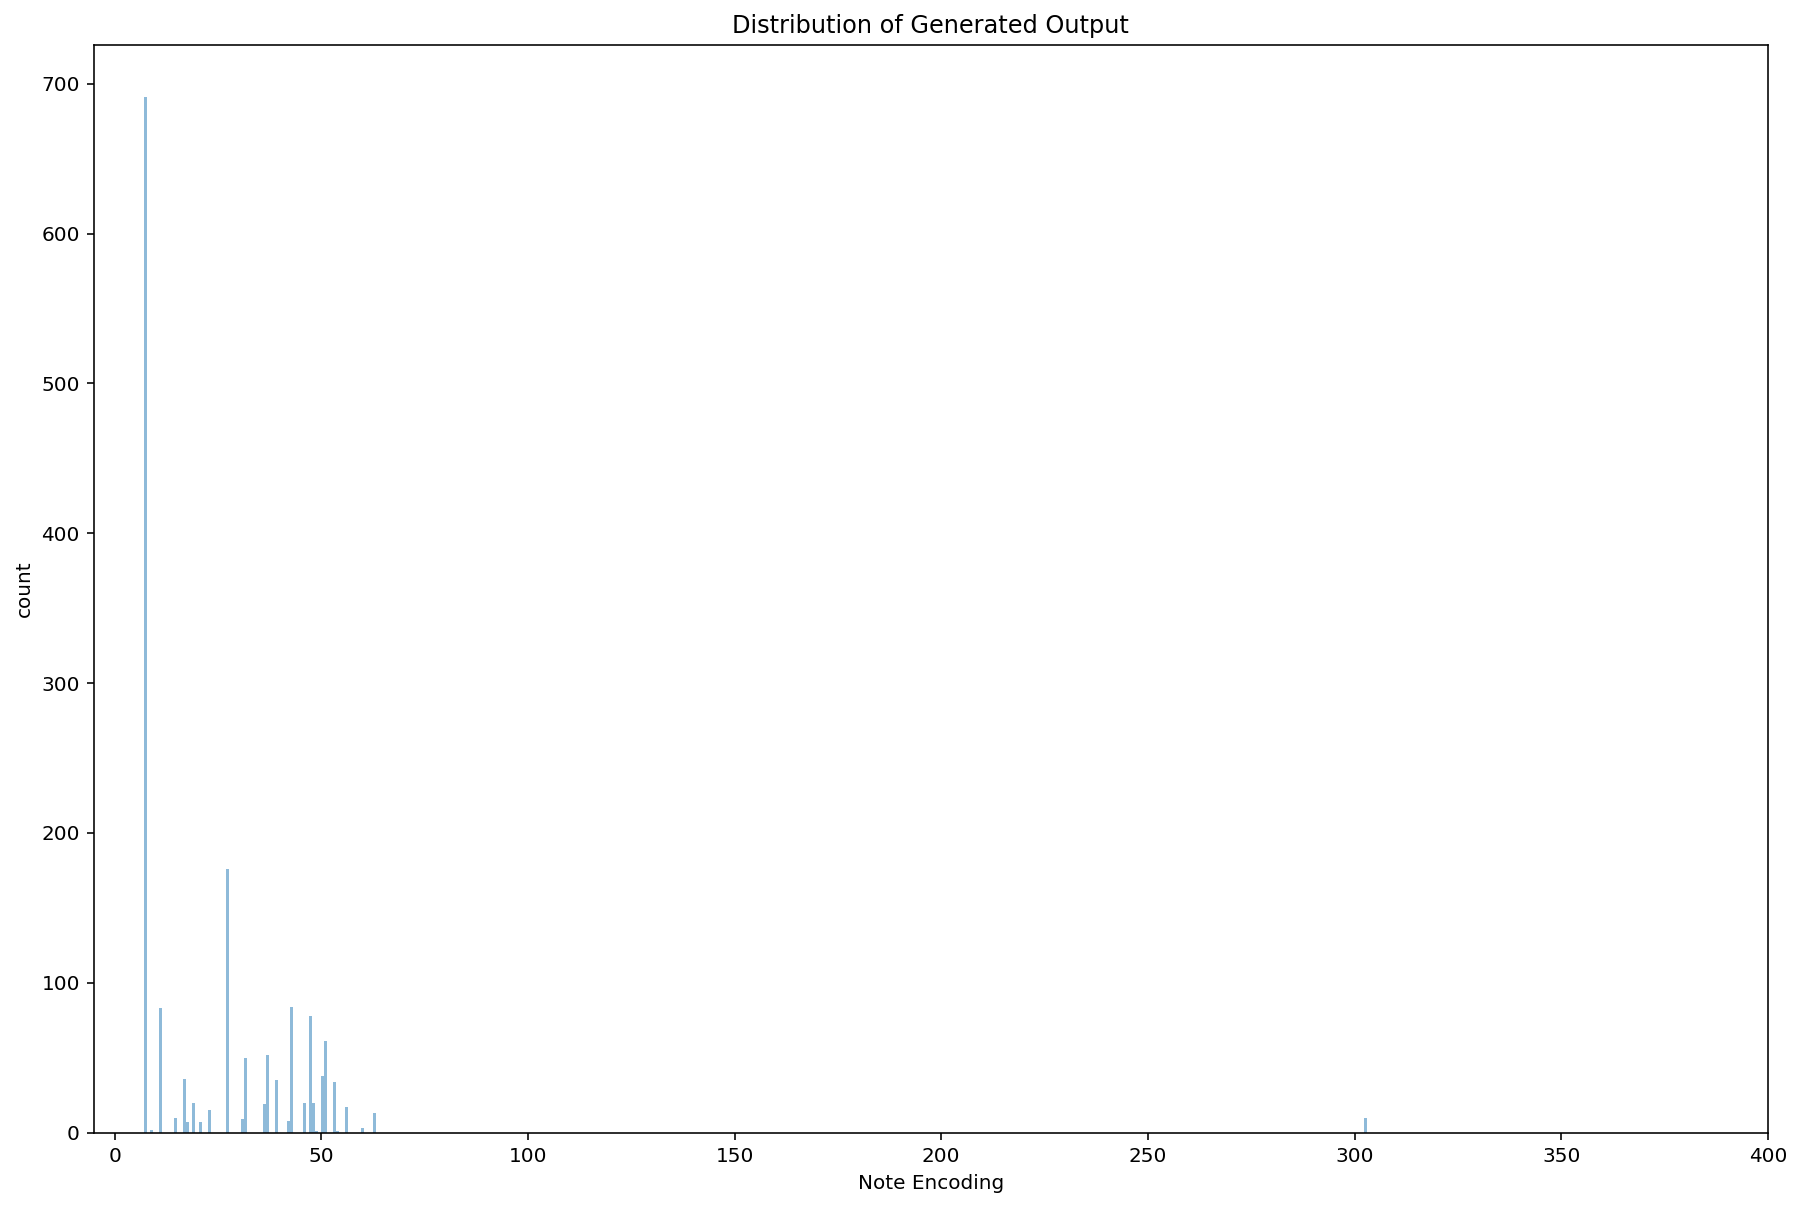

In [26]:
show_gen(generated_output)

[3, 3, 3, 44, 41, 3, 3, 3, 58, 36, 32, 3, 41, 497, 32, 41, 33, 41, 33, 41, 25, 26, 30, 30, 26, 31, 27, 31, 27, 32, 30, 3, 3, 3, 32, 65, 30, 3, 32, 65, 3, 3, 39, 54, 36, 3, 3, 41, 43, 39, 43, 47, 3, 43, 39, 39, 3, 43, 58, 36, 51, 41, 3, 53, 43, 3, 3, 53, 77, 39, 31, 3, 47, 33, 58, 36, 3, 41, 41, 41, 48, 47, 3, 58, 36, 47, 46, 29, 44, 44, 30, 3, 3, 49, 41, 31, 3, 3, 3, 3, 43, 32, 3, 31, 41, 31, 41, 41, 41, 584, 54, 56, 53, 58, 54, 59, 56, 63, 58, 61, 47, 46, 48, 46, 47, 46, 48, 46, 47, 46, 37, 32, 3, 32, 37, 37, 41, 3, 41, 37, 28, 19, 33, 14, 3, 3, 5, 28, 33, 5, 389, 44, 41, 934, 1157, 47, 37, 14, 32, 44, 5, 39, 36, 39, 812, 46, 36, 8, 43, 32, 44, 61, 37, 43, 39, 3, 3, 41, 37, 3, 28, 33, 41, 36, 33, 30, 39, 33, 36, 33, 47, 44, 48, 46, 44, 54, 54, 54, 54, 54, 70, 23, 70, 63, 23, 63, 66, 21, 66, 63, 3, 46, 39, 14, 3, 47, 39, 14, 47, 41, 3, 3, 3, 11, 48, 41, 3, 3, 3, 14, 37, 48, 3, 49, 39, 11, 3, 3, 51, 41, 33, 36, 3, 31, 33, 3, 29, 31, 3, 28, 49, 44, 14, 51, 10, 11, 54, 3, 56, 39, 48, 3, 5

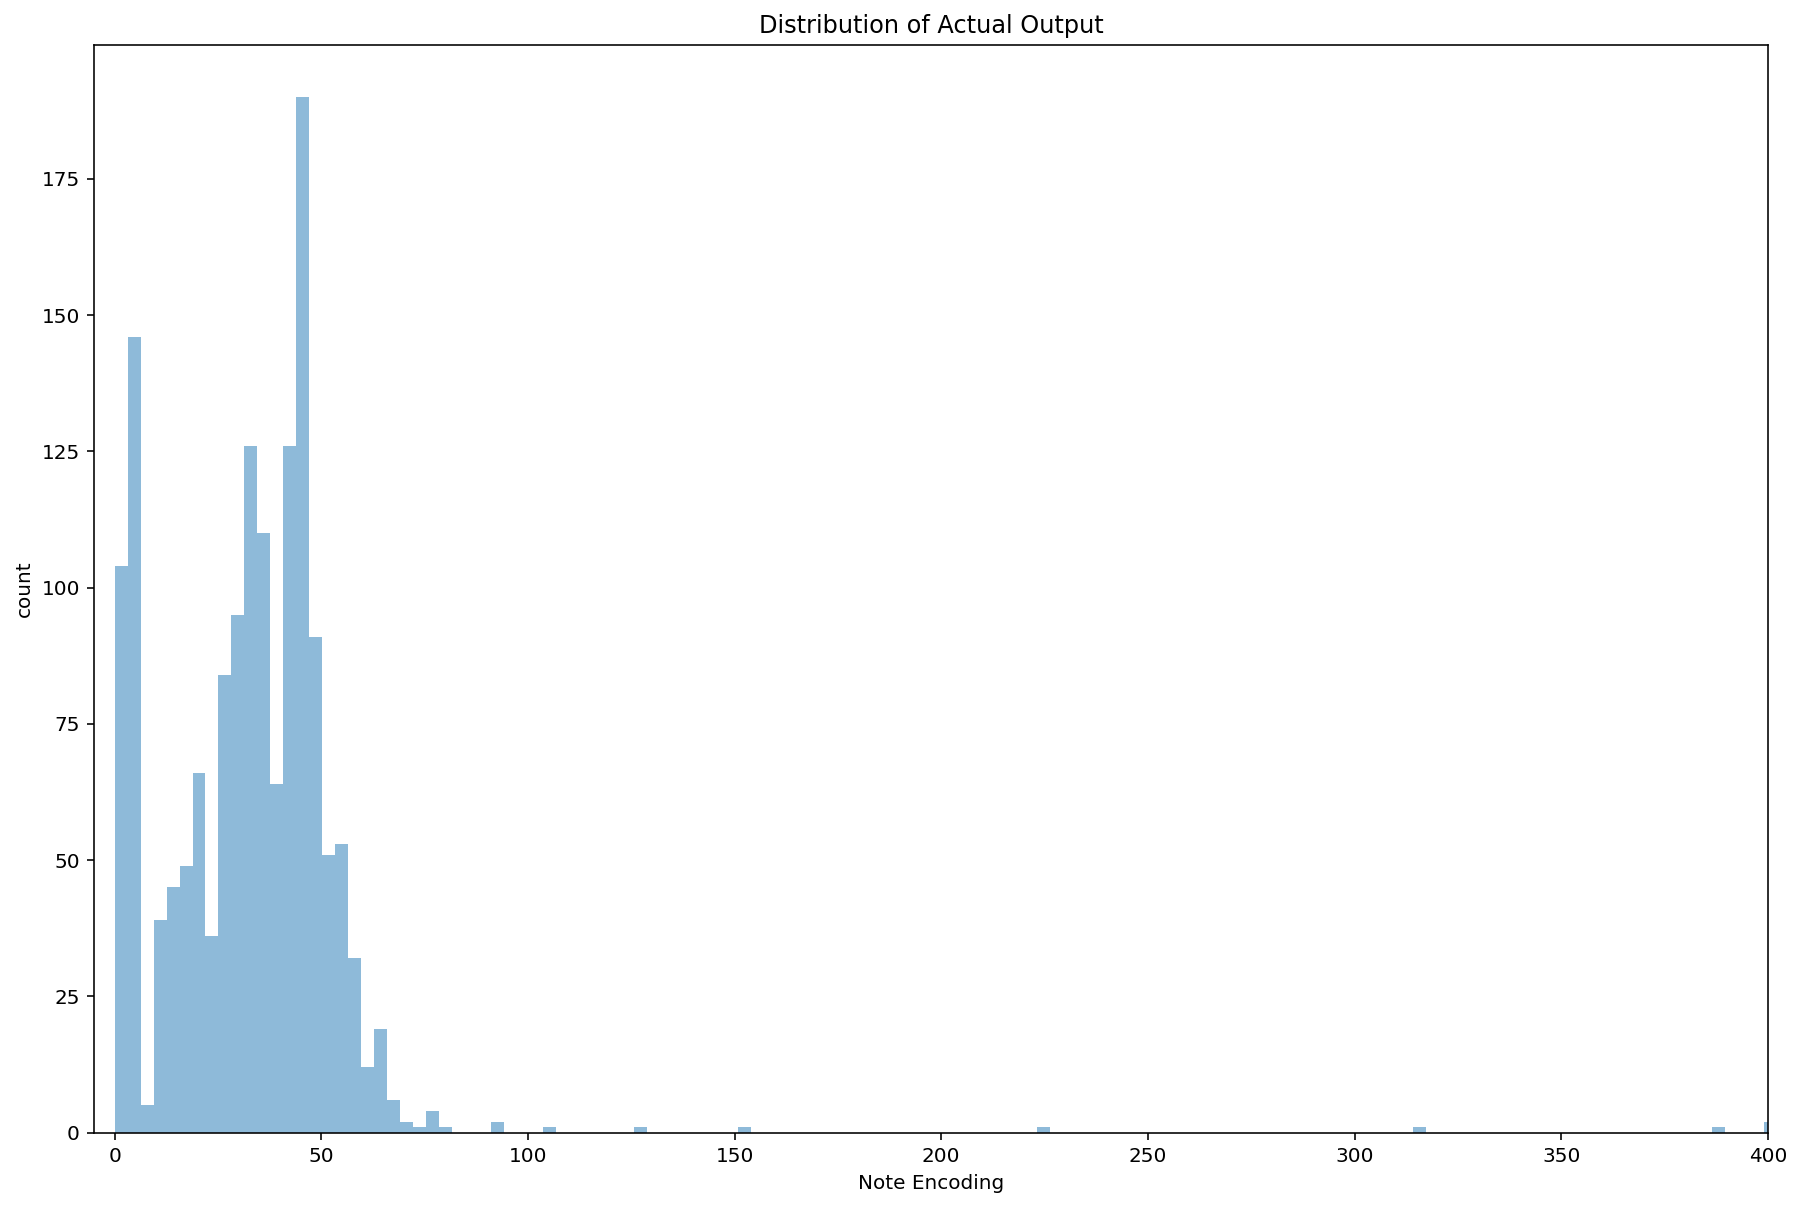

In [27]:
show_actual(network_output)

# RNN 1

In [28]:
network_output_1, generated_output_1, test_1, binds_1, input_1 = generate_rnn('2', '97')
print(network_output_1)
print(generated_output_1)
print(len(network_output_1))
print(len(generated_output_1))
print('\nEvaluating\n\n')
eval(network_output_1, generated_output_1, test_1, binds_1)

Reading Data

Reading Embeddings

Making Sequences
(160, 100, 1)
160

Creating Models
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 100, 512)          263168    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100, 512)          524800    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100, 512)          524800    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 512)               524800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
__________________________________

[44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 38, 44, 44, 44, 44, 44, 44, 44, 44, 38, 44, 44, 44, 38, 38, 44, 44, 44, 44, 38, 38, 38, 38, 38, 38, 38, 38, 38, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 38, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 38, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 38, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44,

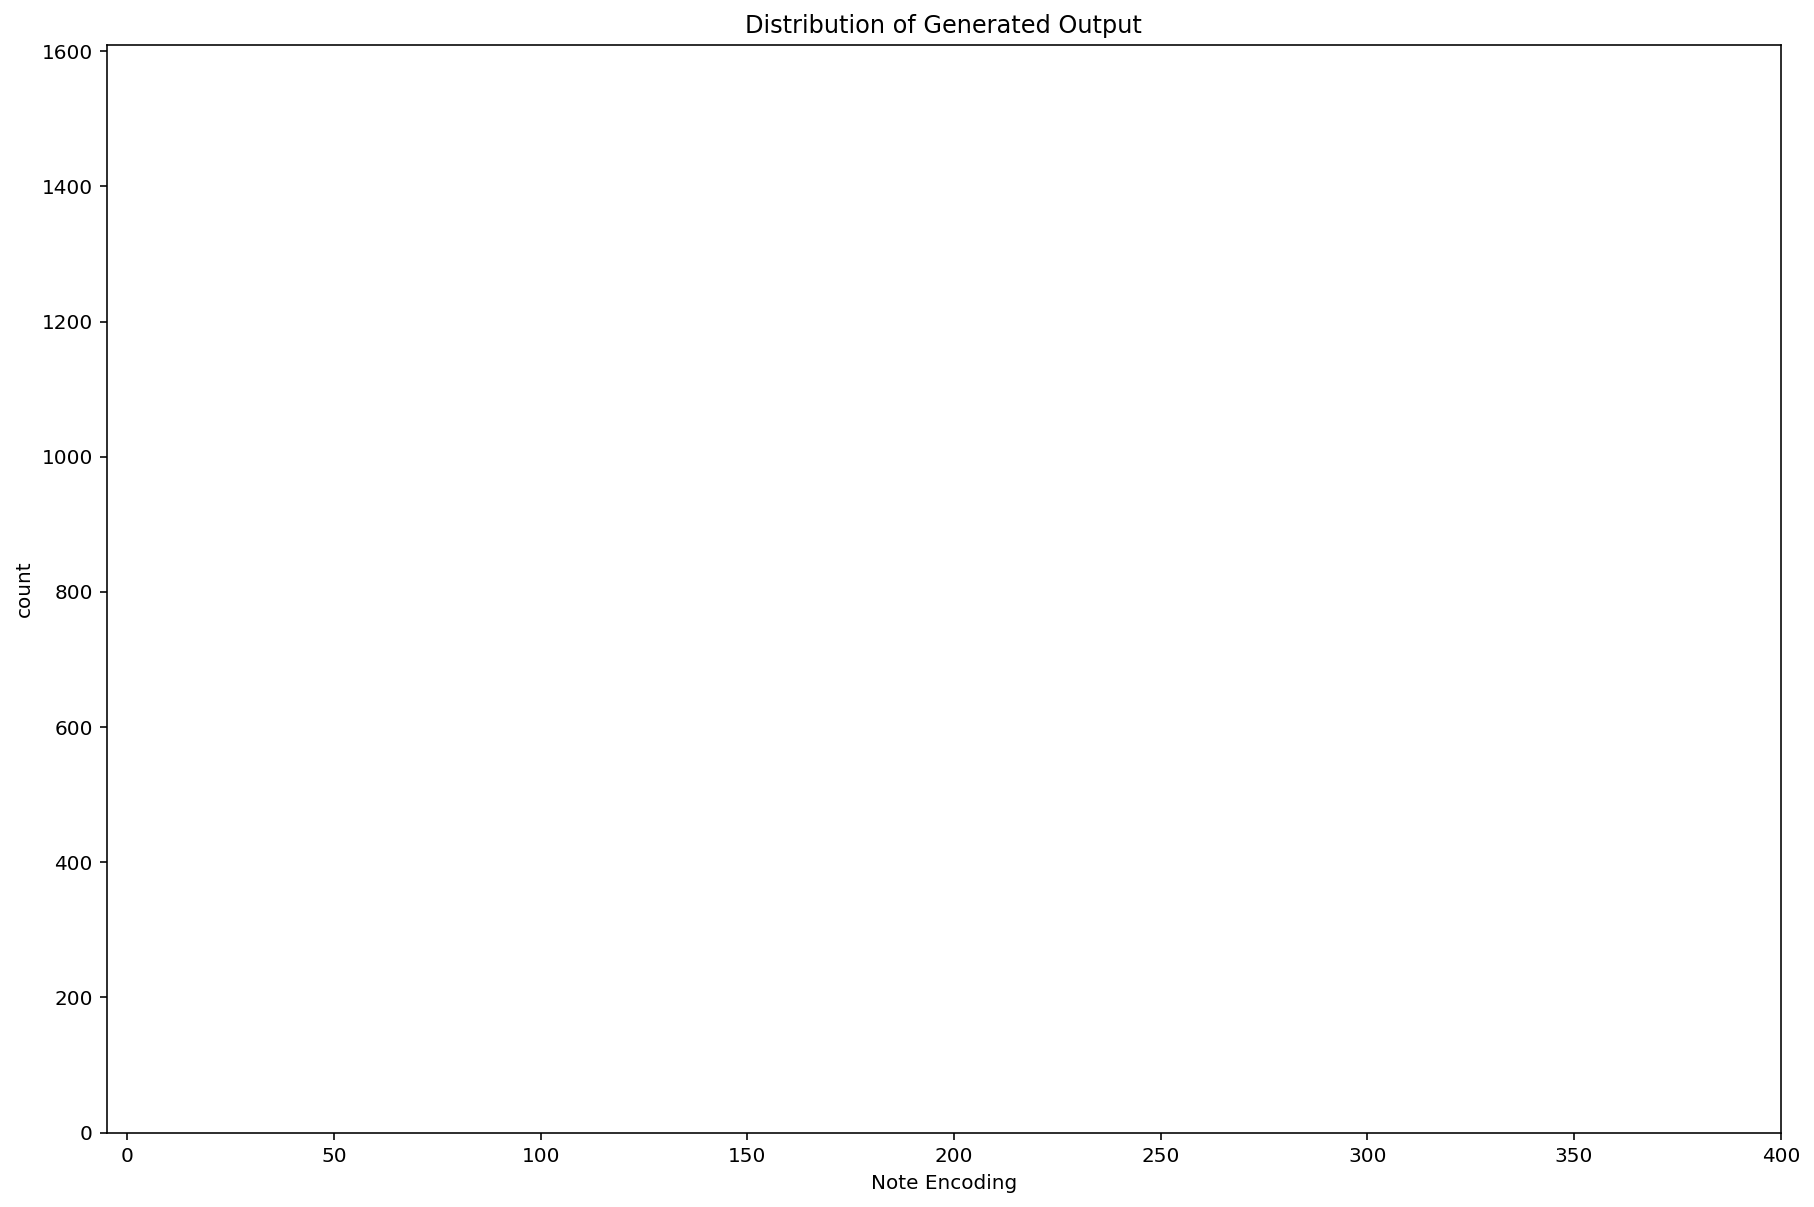

In [37]:
show_gen(generated_output_1)

[3, 3, 3, 44, 41, 3, 3, 3, 58, 36, 32, 3, 41, 497, 32, 41, 33, 41, 33, 41, 25, 26, 30, 30, 26, 31, 27, 31, 27, 32, 30, 3, 3, 3, 32, 65, 30, 3, 32, 65, 3, 3, 39, 54, 36, 3, 3, 41, 43, 39, 43, 47, 3, 43, 39, 39, 3, 43, 58, 36, 51, 41, 3, 53, 43, 3, 3, 53, 77, 39, 31, 3, 47, 33, 58, 36, 3, 41, 41, 41, 48, 47, 3, 58, 36, 47, 46, 29, 44, 44, 30, 3, 3, 49, 41, 31, 3, 3, 3, 3, 43, 32, 3, 31, 41, 31, 41, 41, 41, 584, 54, 56, 53, 58, 54, 59, 56, 63, 58, 61, 47, 46, 48, 46, 47, 46, 48, 46, 47, 46, 37, 32, 3, 32, 37, 37, 41, 3, 41, 37, 28, 19, 33, 14, 3, 3, 5, 28, 33, 5, 389, 44, 41, 934, 1157, 47, 37, 14, 32, 44, 5, 39, 36, 39, 812, 46, 36, 8, 43, 32, 44, 61, 37, 43, 39, 3, 3, 41, 37, 3, 28, 33, 41, 36, 33, 30, 39, 33, 36, 33, 47, 44, 48, 46, 44, 54, 54, 54, 54, 54, 70, 23, 70, 63, 23, 63, 66, 21, 66, 63, 3, 46, 39, 14, 3, 47, 39, 14, 47, 41, 3, 3, 3, 11, 48, 41, 3, 3, 3, 14, 37, 48, 3, 49, 39, 11, 3, 3, 51, 41, 33, 36, 3, 31, 33, 3, 29, 31, 3, 28, 49, 44, 14, 51, 10, 11, 54, 3, 56, 39, 48, 3, 5

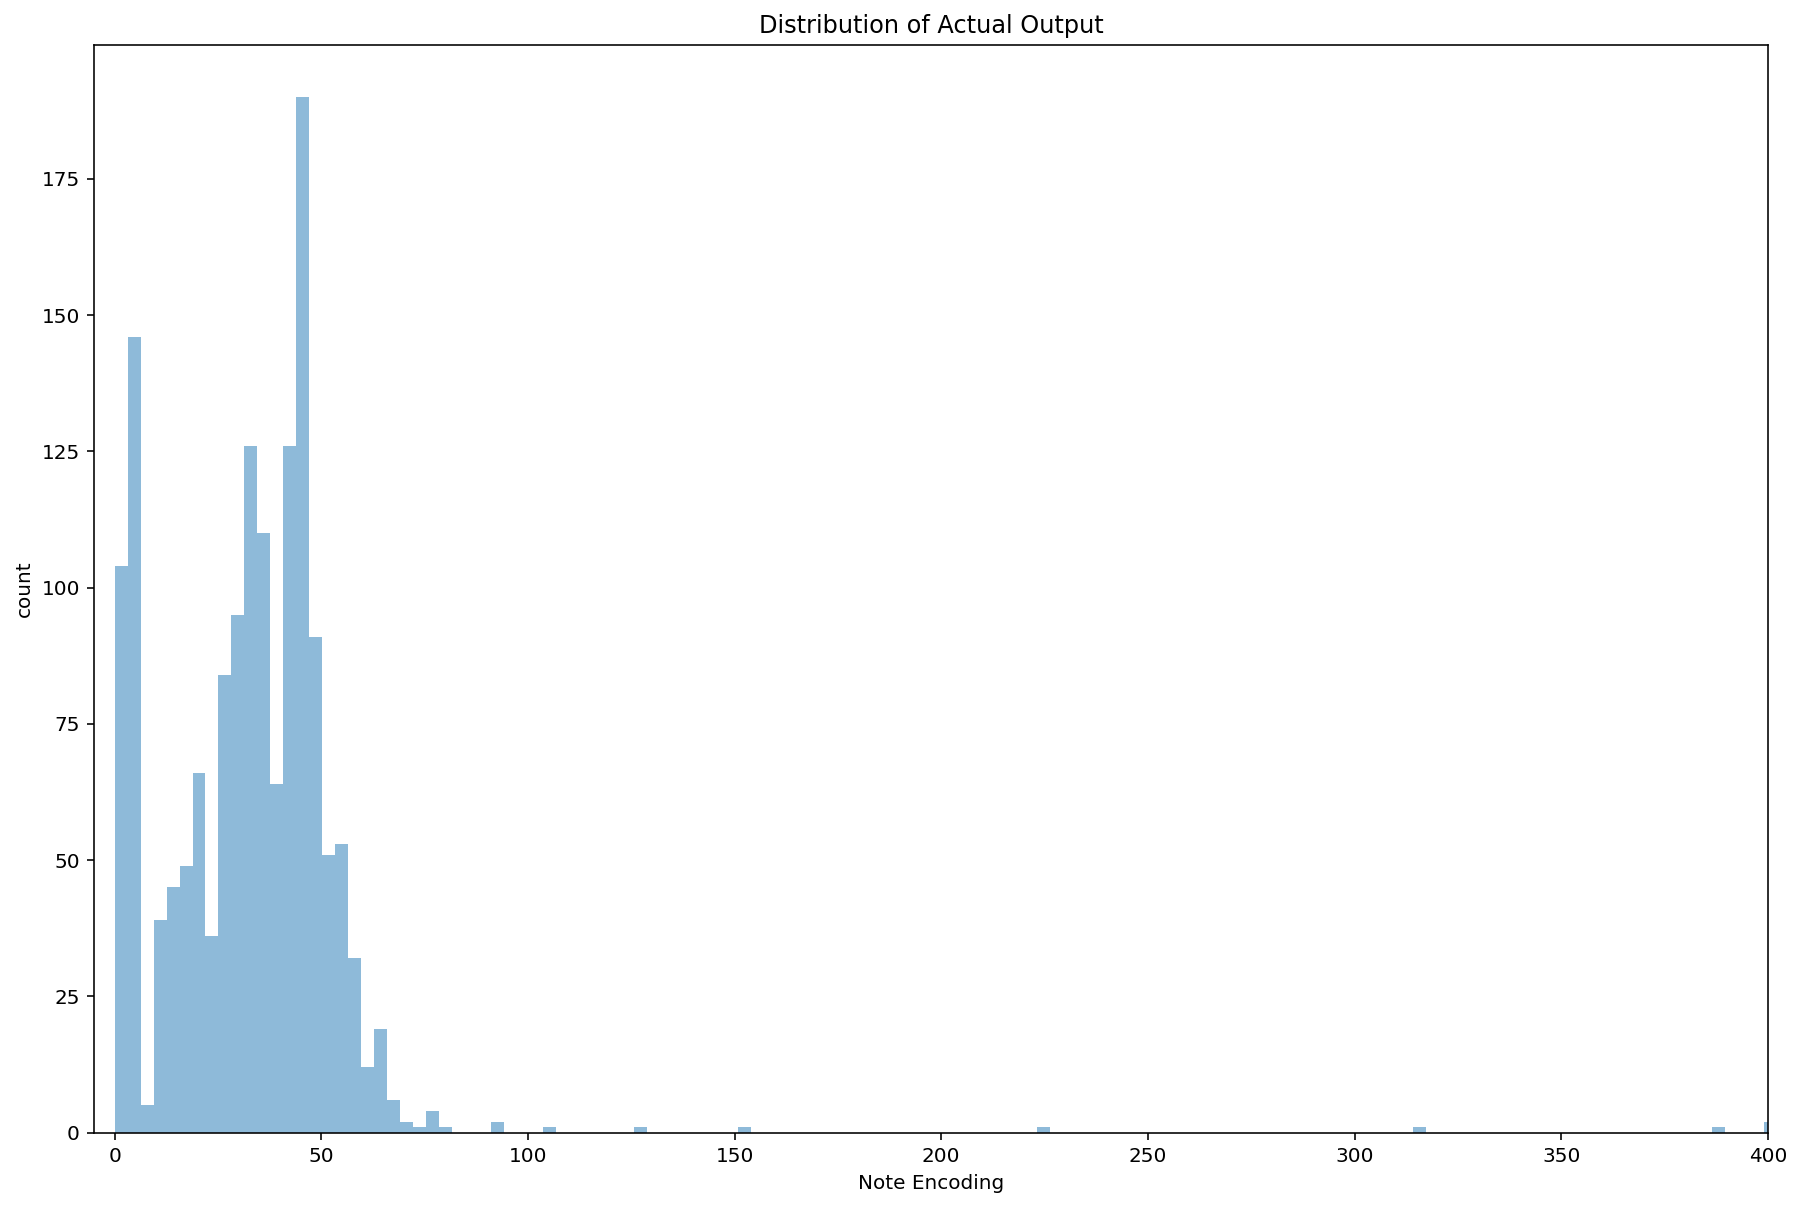

In [30]:
show_actual(network_output_1)

# LSTM 2

In [31]:
network_output_2, generated_output_2, test_2, binds_2, input_2 = generate_lstm('3', '20')
print(network_output_2)
print(generated_output_2)
print(len(network_output_2))
print(len(generated_output_2))
print('\nEvaluating\n\n')
eval(network_output_2, generated_output_2, test_2, binds_2)

Reading Data

Reading Embeddings

Making Sequences
(160, 100, 1)
160

Creating Models
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100, 256)          264192    
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 128)          197120    
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 128)          131584    
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________________________________

[3, 3, 3, 4, 4, 47, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 45, 3, 3, 3, 4, 47, 3, 3, 3, 3, 3, 3, 47, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 41, 3, 3, 41, 3, 3, 3, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 41, 34, 34, 45, 34, 34, 34, 5, 34, 34, 5, 34, 41, 34, 34, 5, 5, 41, 41, 41, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 51, 51, 51, 51, 51, 51, 49, 51, 51, 51, 61, 66, 19, 66, 61, 19, 61, 65, 19, 65, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 4, 3, 3, 3, 3, 51, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 15, 3, 3, 15, 3, 15, 3, 15, 3, 3, 51, 3, 3, 51, 51, 3, 3, 51, 51, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4, 4, 3, 4, 3, 47, 3, 3, 3, 3, 3, 3, 3, 3, 50, 47, 50, 47, 

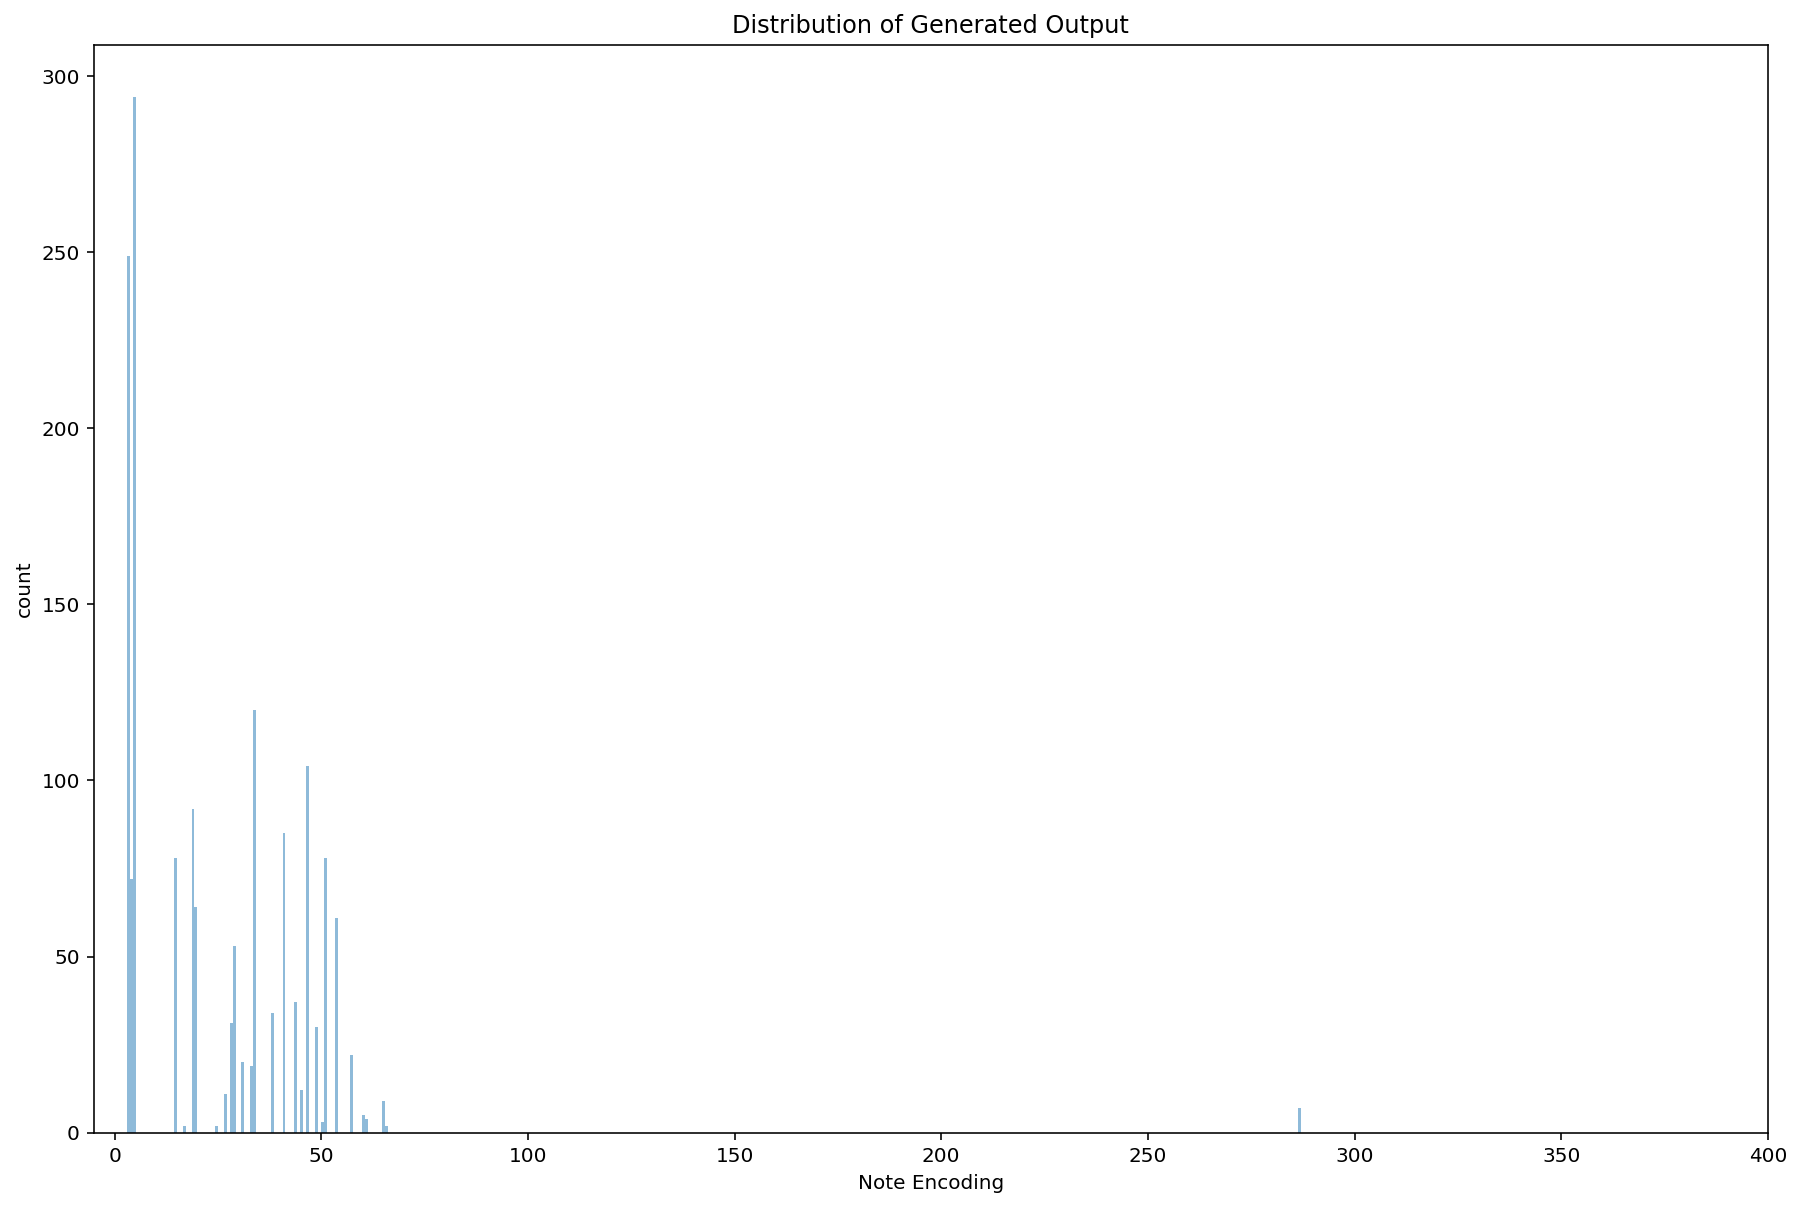

In [32]:
show_gen(generated_output_2)

[3, 3, 3, 44, 41, 3, 3, 3, 58, 36, 32, 3, 41, 497, 32, 41, 33, 41, 33, 41, 25, 26, 30, 30, 26, 31, 27, 31, 27, 32, 30, 3, 3, 3, 32, 65, 30, 3, 32, 65, 3, 3, 39, 54, 36, 3, 3, 41, 43, 39, 43, 47, 3, 43, 39, 39, 3, 43, 58, 36, 51, 41, 3, 53, 43, 3, 3, 53, 77, 39, 31, 3, 47, 33, 58, 36, 3, 41, 41, 41, 48, 47, 3, 58, 36, 47, 46, 29, 44, 44, 30, 3, 3, 49, 41, 31, 3, 3, 3, 3, 43, 32, 3, 31, 41, 31, 41, 41, 41, 584, 54, 56, 53, 58, 54, 59, 56, 63, 58, 61, 47, 46, 48, 46, 47, 46, 48, 46, 47, 46, 37, 32, 3, 32, 37, 37, 41, 3, 41, 37, 28, 19, 33, 14, 3, 3, 5, 28, 33, 5, 389, 44, 41, 934, 1157, 47, 37, 14, 32, 44, 5, 39, 36, 39, 812, 46, 36, 8, 43, 32, 44, 61, 37, 43, 39, 3, 3, 41, 37, 3, 28, 33, 41, 36, 33, 30, 39, 33, 36, 33, 47, 44, 48, 46, 44, 54, 54, 54, 54, 54, 70, 23, 70, 63, 23, 63, 66, 21, 66, 63, 3, 46, 39, 14, 3, 47, 39, 14, 47, 41, 3, 3, 3, 11, 48, 41, 3, 3, 3, 14, 37, 48, 3, 49, 39, 11, 3, 3, 51, 41, 33, 36, 3, 31, 33, 3, 29, 31, 3, 28, 49, 44, 14, 51, 10, 11, 54, 3, 56, 39, 48, 3, 5

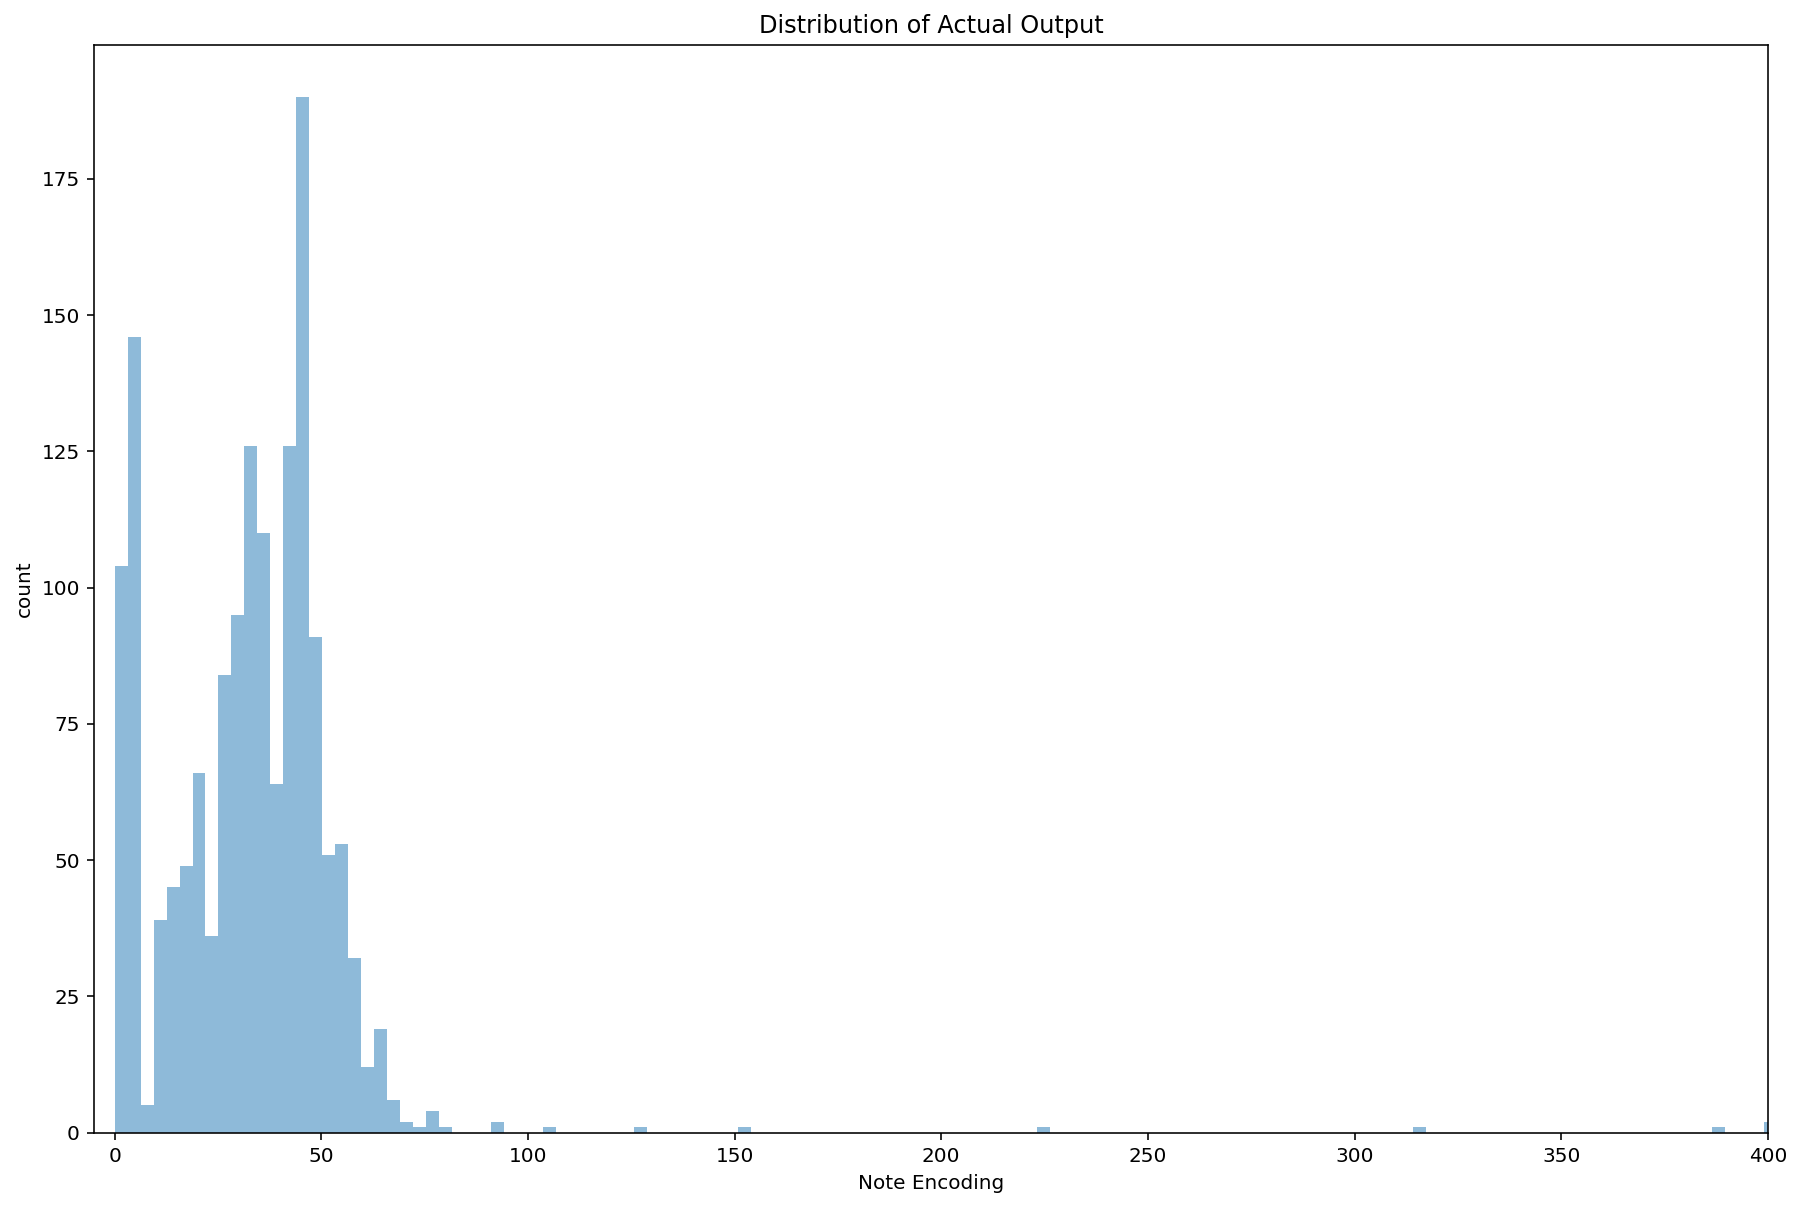

In [33]:
show_actual(network_output_2)

# RNN 2

In [34]:
network_output_3, generated_output_3, test_3, binds_3, input_3 = generate_rnn('4', '19')
print(network_output_3)
print(generated_output_3)
print(len(network_output_3))
print(len(generated_output_3))
print('\nEvaluating\n\n')
eval(network_output_3, generated_output_3, test_3, binds_3)

Reading Data

Reading Embeddings

Making Sequences
(160, 100, 1)
160

Creating Models
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 100, 512)          263168    
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 100, 512)          524800    
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 100, 512)          524800    
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 512)               524800    
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
__________________________________

[1, 47, 47, 3, 3, 255, 47, 47, 47, 47, 41, 3, 47, 47, 3, 3, 47, 47, 3, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 2, 2, 1, 3, 3, 3, 41, 40, 40, 40, 41, 40, 40, 41, 40, 1, 47, 255, 47, 255, 47, 3, 255, 47, 47, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 255, 3, 3, 3, 3, 3, 3, 3, 3, 3, 47, 47, 40, 57, 40, 3, 47, 47, 40, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 41, 40, 3, 3, 3, 3, 3, 255, 3, 40, 3, 3, 3, 3, 3, 40, 3, 3, 3, 255, 1, 1, 1, 1, 1, 1, 3, 1, 1, 47, 41, 41, 40, 41, 3, 3, 41, 41, 41, 3, 2, 1, 1, 3, 1, 3, 3, 3, 1, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 47, 47, 47, 47, 47, 47, 40, 47, 47, 47, 41, 255, 3, 255, 255, 3, 255, 255, 46, 255, 1, 3, 3, 3, 3, 41, 41, 3, 41, 41, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 47, 47, 47, 3, 3, 47, 47, 3, 3, 47, 3, 2, 2, 3, 3, 3, 2, 3, 2, 2, 3, 41, 40, 3, 3, 3, 3, 3, 41, 40, 40, 1, 1, 3, 3, 1, 1, 3, 3, 1, 47, 41, 40, 3, 3, 41, 41, 3, 41, 3, 3, 2, 2, 1, 

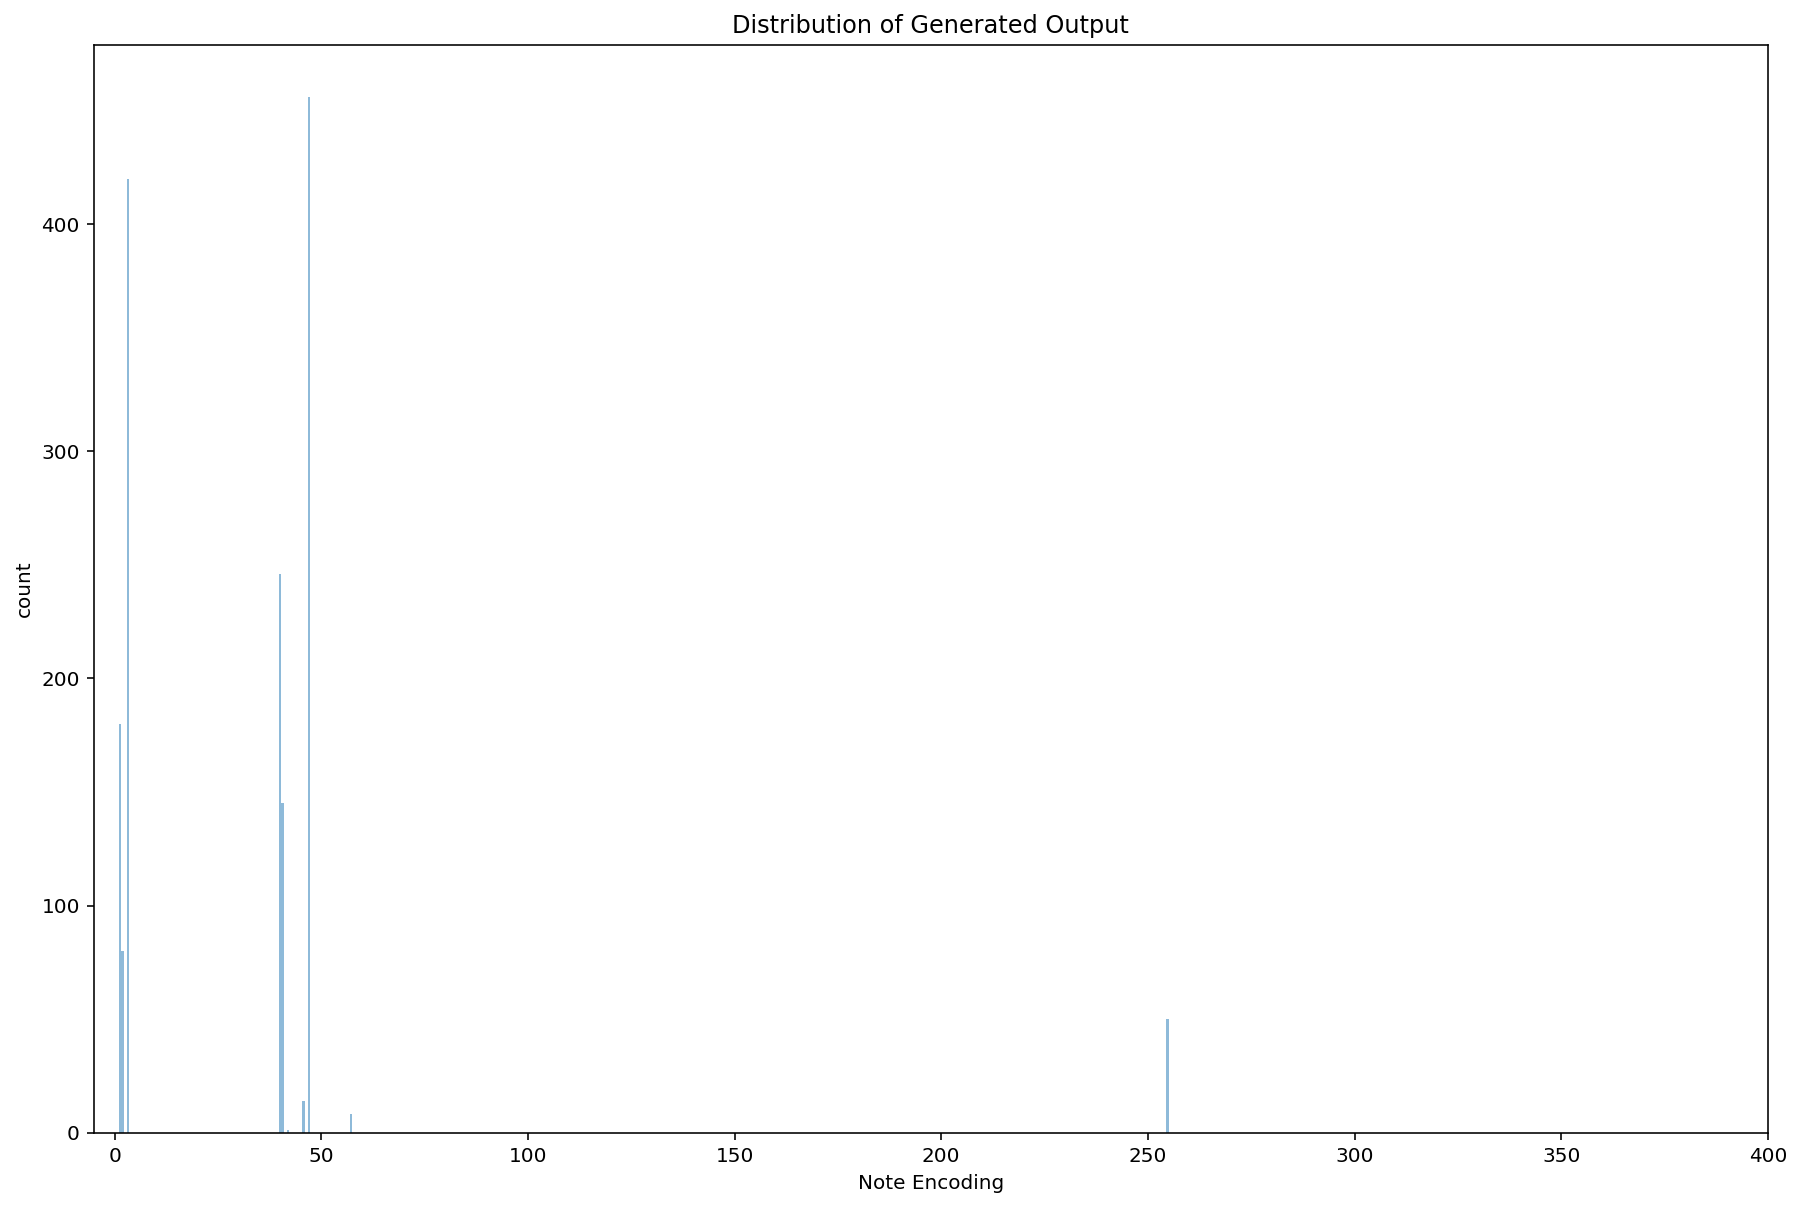

In [35]:
show_gen(generated_output_3)

[3, 3, 3, 44, 41, 3, 3, 3, 58, 36, 32, 3, 41, 497, 32, 41, 33, 41, 33, 41, 25, 26, 30, 30, 26, 31, 27, 31, 27, 32, 30, 3, 3, 3, 32, 65, 30, 3, 32, 65, 3, 3, 39, 54, 36, 3, 3, 41, 43, 39, 43, 47, 3, 43, 39, 39, 3, 43, 58, 36, 51, 41, 3, 53, 43, 3, 3, 53, 77, 39, 31, 3, 47, 33, 58, 36, 3, 41, 41, 41, 48, 47, 3, 58, 36, 47, 46, 29, 44, 44, 30, 3, 3, 49, 41, 31, 3, 3, 3, 3, 43, 32, 3, 31, 41, 31, 41, 41, 41, 584, 54, 56, 53, 58, 54, 59, 56, 63, 58, 61, 47, 46, 48, 46, 47, 46, 48, 46, 47, 46, 37, 32, 3, 32, 37, 37, 41, 3, 41, 37, 28, 19, 33, 14, 3, 3, 5, 28, 33, 5, 389, 44, 41, 934, 1157, 47, 37, 14, 32, 44, 5, 39, 36, 39, 812, 46, 36, 8, 43, 32, 44, 61, 37, 43, 39, 3, 3, 41, 37, 3, 28, 33, 41, 36, 33, 30, 39, 33, 36, 33, 47, 44, 48, 46, 44, 54, 54, 54, 54, 54, 70, 23, 70, 63, 23, 63, 66, 21, 66, 63, 3, 46, 39, 14, 3, 47, 39, 14, 47, 41, 3, 3, 3, 11, 48, 41, 3, 3, 3, 14, 37, 48, 3, 49, 39, 11, 3, 3, 51, 41, 33, 36, 3, 31, 33, 3, 29, 31, 3, 28, 49, 44, 14, 51, 10, 11, 54, 3, 56, 39, 48, 3, 5

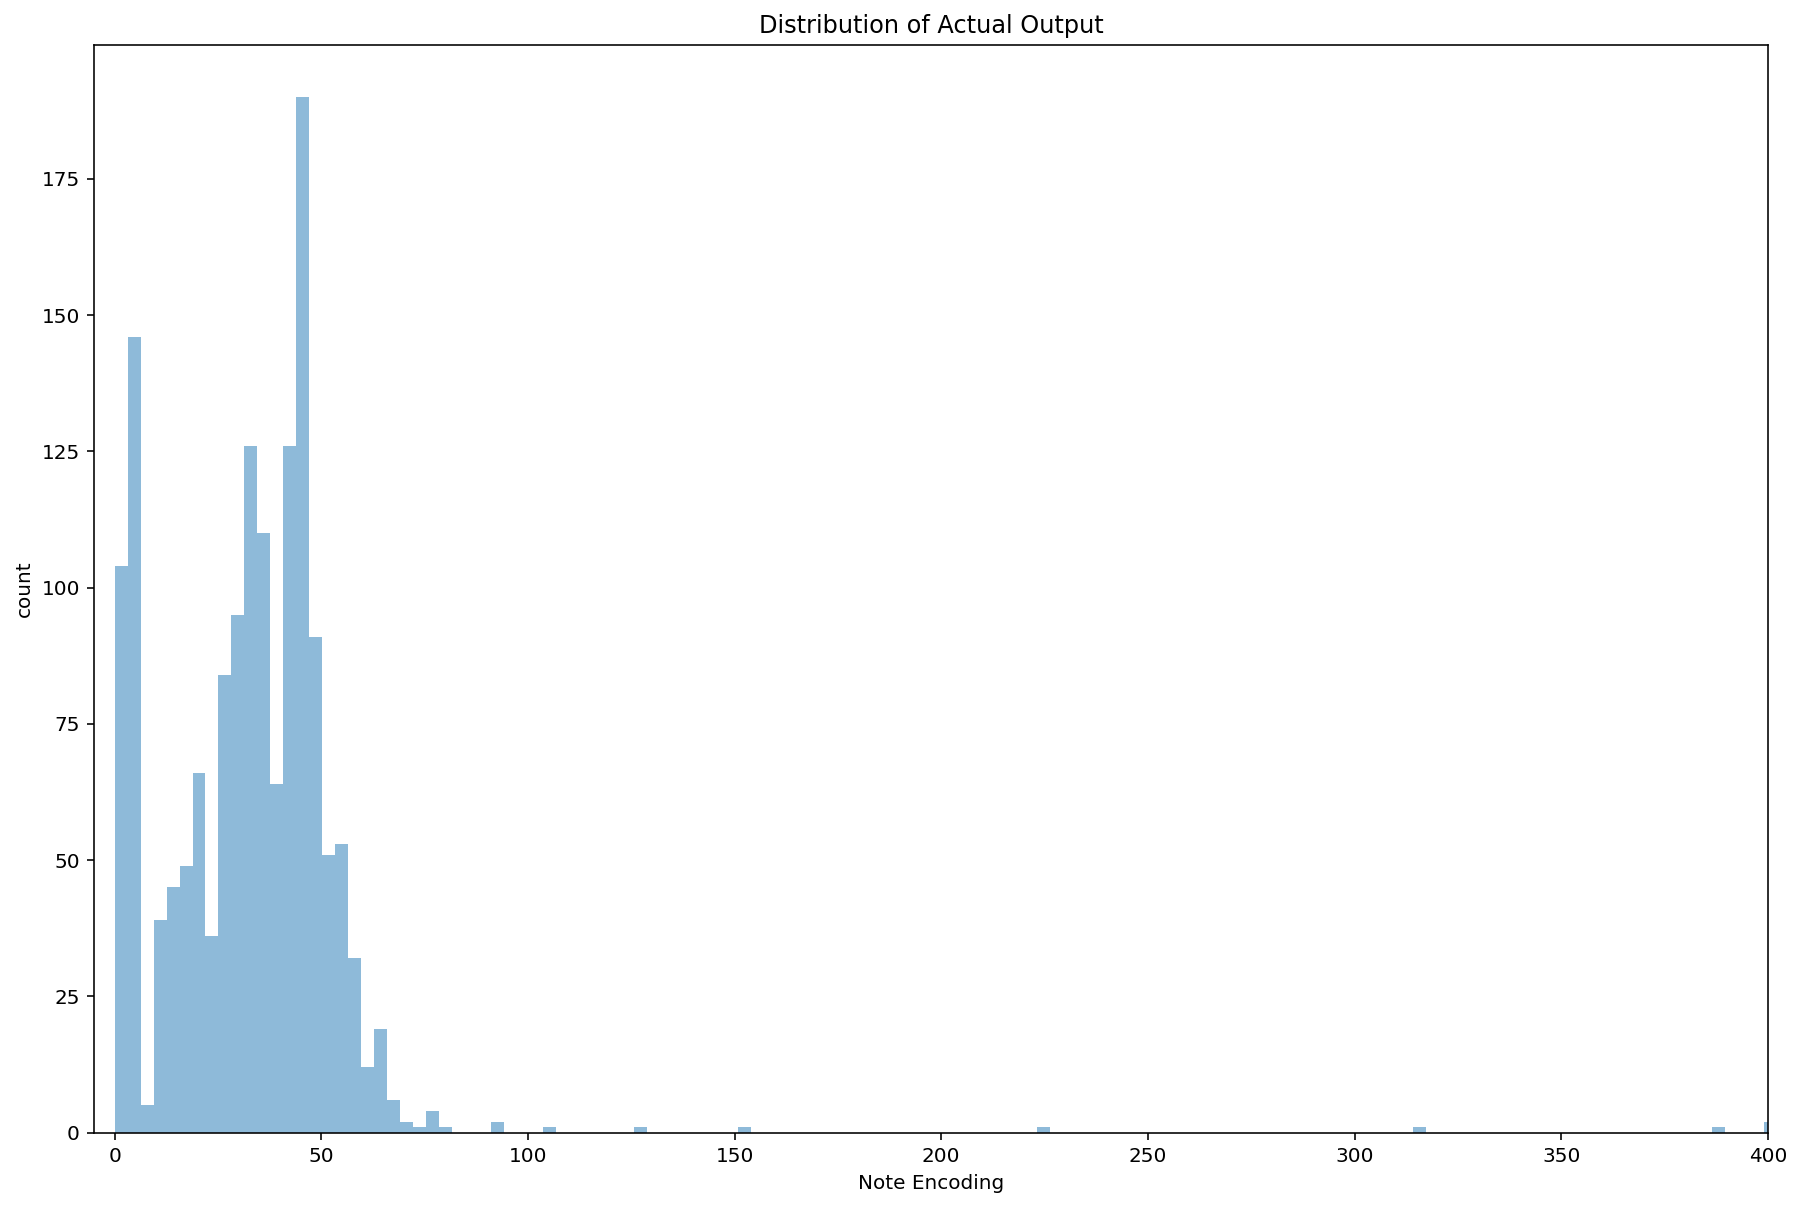

In [36]:
show_actual(network_output_3)